# "mcmcPPCA" examples

In this notebook, we demonstrate examples of `emPPCA` applied on various datasets. 

To load the module:

In [1]:
import sys
sys.path.append('../')
from replicatePPCA import mcmcPPCA

There are other modules required in this notebook for pre-processing and visualizing:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors as NN
from numpy.random import normal
from numpy.linalg import inv, det, eig
from natsort import index_natsorted

---

# 1 &nbsp; Tobomovirus dataset

In [3]:
# Dataframe loading
virus = pd.read_csv('../datasets/tobomovirus/virus3.txt', delimiter='\s+', header=None).values

# Synthetic replicates of different perturbation
np.random.seed(123)
R = 4
name_rep = []
Y = []
perturb = []
scale = 3 / (R-1)
for r in range(R):
    perturb.append(np.random.normal(loc=0.0, scale=scale*r, size=virus.shape)) # Record perturbations added
    Y.append(virus + perturb[r]) # Add random perturbation, and append to the list of observations
    
# Concatenate replicates to standardise together
Y_concat = np.concatenate(Y)
scaler_virus = StandardScaler()
Y_concat = scaler_virus.fit_transform(Y_concat)

# Split replicates back to the required form
counter = 0
for r in range(R):
    Y[r] = Y_concat[counter:(counter+Y[r].shape[0]), :]
    counter += Y[r].shape[0]

## 1.1 &nbsp; Package usage
Below we create the `tobomovirus` instance. For simplicity, we only fit the first two principal components.

The optimization process of Markov chain Monte Carlo algorithm depends on the initial parameters. The creation of `mcmcPPCA` instance includes a random initialization of PPCA parameters. The initialized variances will be printed.

Alternatively, users can specify the initial states manually. As an example:

In [4]:
# Manual initial states
p = Y[0].shape[1]
q = 2
R = len(Y)
W = normal(loc=0, scale=1, size=(p, q))
X = [rep @ W @ inv(W.T @ W) for rep in Y] # Collect in rows each x_i, size n*q
recon = [rep @ W.T for rep in X]
n = [rep.shape[0] for rep in Y] # Numbers of observations are different across replicates
sigma = [np.sum((recon[r]-Y[r])**2) / (n[r] * p) for r in range(R)]

# Run MCMC
tobomovirus = mcmcPPCA(Y=Y, q=q, W=W, sigma=sigma, X=X)

Set hyper parameters for prior and proposal distributions. 

In [5]:
tobomovirus.set_priors(W=1, sigma=[3, 1], X=1)
tobomovirus.set_proposals(W=0.015, sigma=[51, 50], X=0.055)

Users can specify the number of iterations of sampling for the `.fit()` method. The default number is $50000$.
Normally a single sampling process could take half an hour. Users could save or load the instance via `.save()` or `.load()` method.

In [6]:
tobomovirus.fit(iterations=10000)
tobomovirus.save('tobomovirus')
tobomovirus.load('mcmc_output_results/tobomovirus')

  0%|          | 0/10000 [00:00<?, ?it/s]

Current acceptance rates: W, 0.7157157157157259; sigma, 0.3981481481481493; X, 0.34184184184184324
Current acceptance rates: W, 0.6518259129564882; sigma, 0.4048274137068599; X, 0.3889444722361241
Current acceptance rates: W, 0.5975325108369343; sigma, 0.40913637879293896; X, 0.43772924308102584
Current acceptance rates: W, 0.5576394098524425; sigma, 0.40966491622905293; X, 0.4669917479369733
Current acceptance rates: W, 0.5359071814362608; sigma, 0.41008201640326813; X, 0.48379675935184974
Current acceptance rates: W, 0.5235872645440602; sigma, 0.41036006000998365; X, 0.4954575762626831
Current acceptance rates: W, 0.5130732961851361; sigma, 0.4102014573510283; X, 0.5043220460065402
Current acceptance rates: W, 0.5003125390673487; sigma, 0.41298912364042994; X, 0.5161582697836864
Current acceptance rates: W, 0.49527725302807785; sigma, 0.41371263473716563; X, 0.5215579508833922
Current acceptance rates: W, 0.491849184918454; sigma, 0.41411641164113483; X, 0.5237523752374823


To inspect the convergence of Markov chain Monte Carlo, the usual method is inspect the change in total log-likelihood. \
Eventually, the likelihood should increase to certain value and starts oscillation.

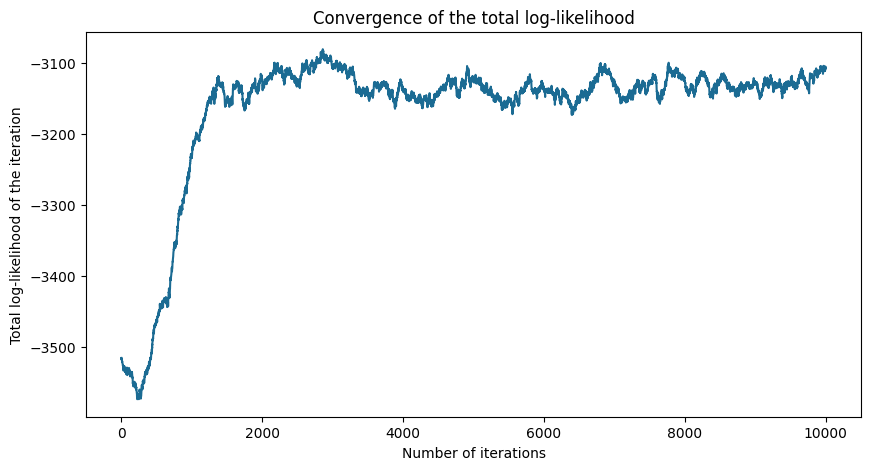

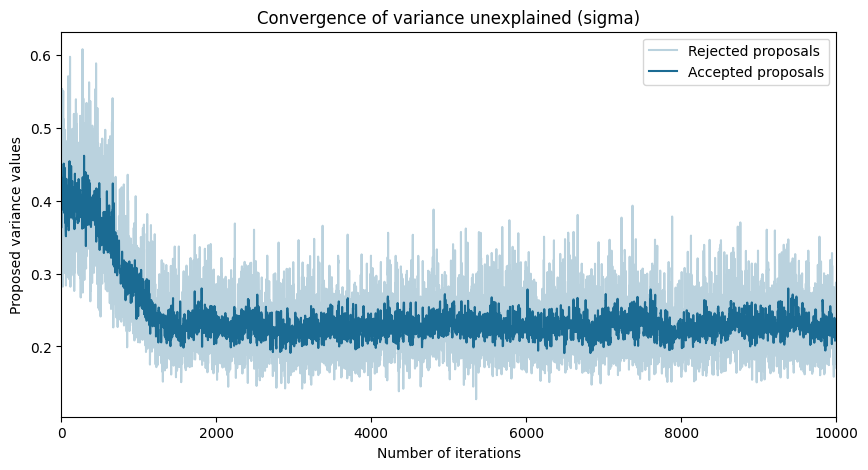

In [7]:
tobomovirus.plot_likelihood()
tobomovirus.plot_sigma(r=1)

In [8]:
tobomovirus.post_process(5000)

The default visualization distinguishes each replicate in a single subplot. 

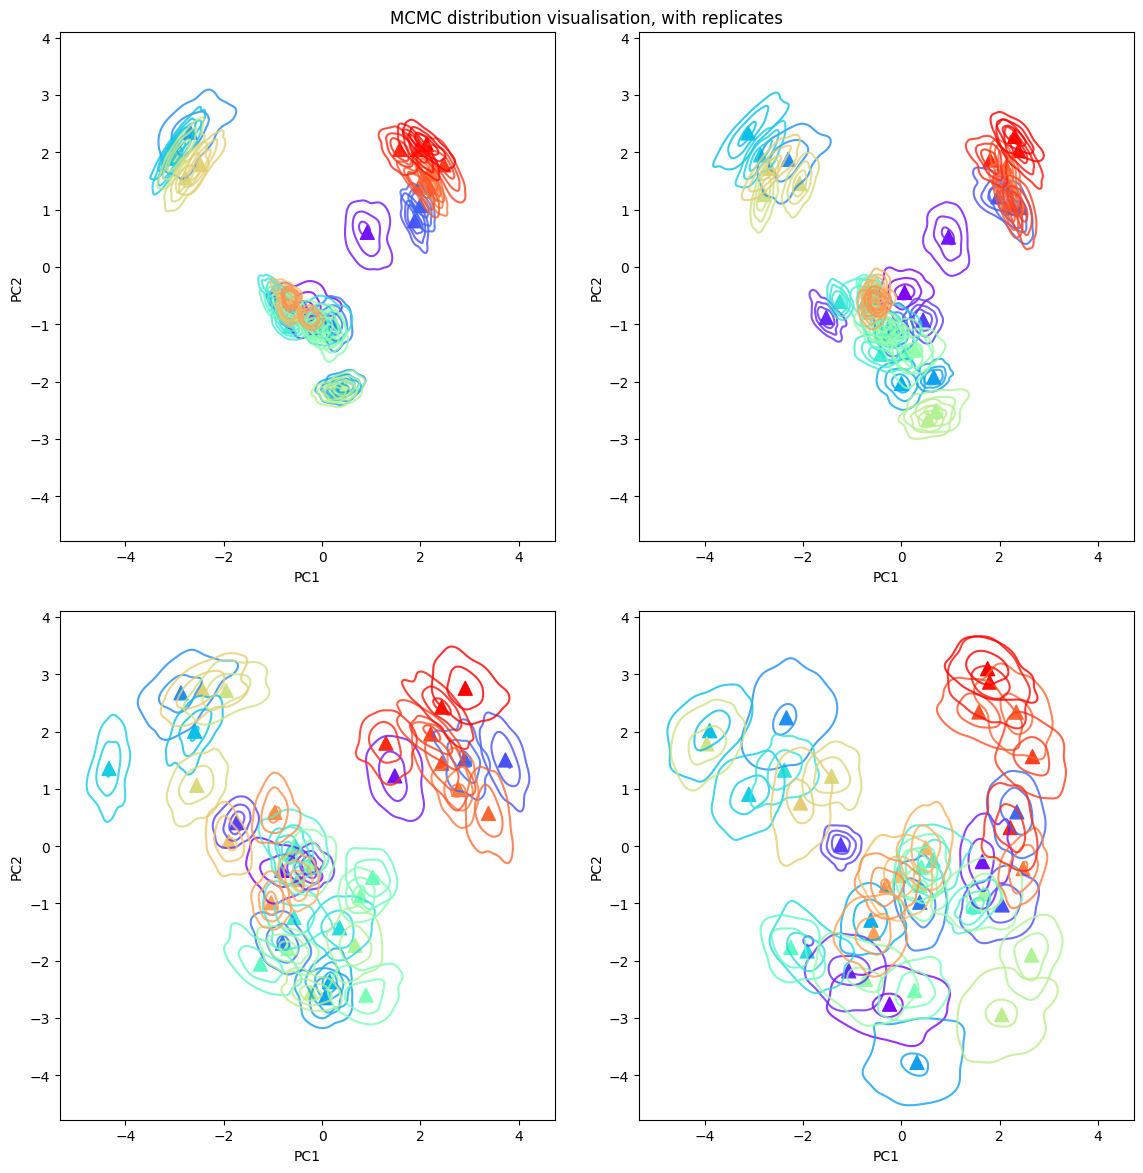

In [9]:
tobomovirus.X_contours(repwise=True, savefig='tobomovirus_repwise', reduct_proportion=0.5)

Users can plot all replicates in the same plot via specifying `repwise=False`. The method can also visualize part of the replicates by specifying a list of replicate numbers via `reps`.

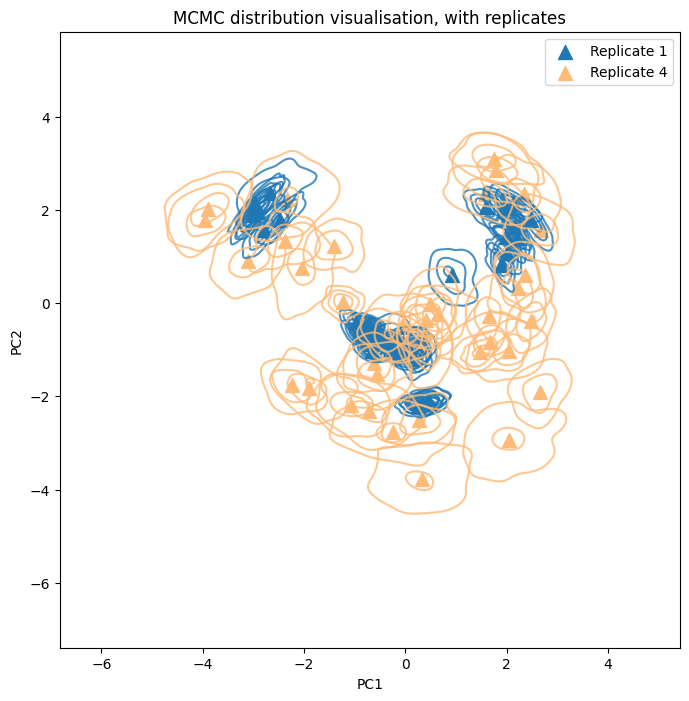

In [10]:
tobomovirus.X_contours(repwise=False, reps=[1,4], savefig='tobomovirus_1vs4')

---

# 2 &nbsp; pSCoPE dataset

#### Load data & Read replicates guide

In [17]:
data = pd.read_csv('../datasets/pSCoPE/processed.csv',index_col=0).T
guide = pd.read_csv('../datasets/pSCoPE/guide.csv',index_col=0)
n,p = data.shape
guide = guide[guide.index.isin(data.index)] # Only retain ids that appear in processed data file
guide

,RI,Raw.file,celltype,lcbatch,sortday,digest,cvm
id,,,,,,,
i10,Reporter.intensity.corrected.10,XwGH0500,untreated,B,B,C,0.353338
i102,Reporter.intensity.corrected.6,XwGH0526,LPS,B,B,C,0.291037
i103,Reporter.intensity.corrected.7,XwGH0526,LPS,B,B,C,0.302209
i104,Reporter.intensity.corrected.8,XwGH0526,LPS,B,B,C,0.345369
i105,Reporter.intensity.corrected.9,XwGH0526,LPS,B,B,C,0.295632
...,...,...,...,...,...,...,...
i91,Reporter.intensity.corrected.11,XwGH0513,untreated,B,B,C,0.308977
i92,Reporter.intensity.corrected.12,XwGH0513,untreated,B,B,C,0.312930
i93,Reporter.intensity.corrected.13,XwGH0513,untreated,B,B,C,0.370674


#### The p_v most variate features

In [18]:
p_v = 100
id_v = np.argsort(np.var(data.values, axis=0))[-p_v:]

#### Divide to replicates
$Y_\text{rep} = [R * (n[r] * p)]$

In [19]:
# Number of replicates
R = 40 

# Read replicate-wise
id_rep = [] # Experiments id in replicates, in form ixx; list of index objects
label_rep = [] # "untreated" / "LPS"; "limma-corrected" has removed "control" and some observations
Y_rep = []
for i in range(R):
    id_rep.append(np.array(guide[guide['Raw.file'] == f'XwGH05{i:02d}'].index))
    label_rep.append(np.array(guide.loc[id_rep[i]]['celltype']))
    Y_rep.append(data.loc[id_rep[i]])
    
# Convert to numerical labels
num_label = [np.where(array=='untreated', 0, 1) for array in label_rep] # 'untreated' -> 0; otherwise -> 1

# Standardising replicate-wise
scaler = StandardScaler()
Y = [scaler.fit_transform(df)[:,id_v] for df in Y_rep]
n = [rep.shape[0] for rep in Y]
p = Y[0].shape[1]

#### Apply MCMC PPCA

In [20]:
pSCoPE = mcmcPPCA(Y, q=2)

Initialised with sigmas: [0.9877248134215023, 0.9836018216931798, 0.9877801772587729, 0.9676006298953745, 0.9700657580105111, 0.9752032702207429, 0.9552161937063004, 0.9784651857800908, 0.9680123948955879, 0.961888854297304, 0.9799127690445352, 0.980334810522565, 0.9786257997696698, 0.986508696196041, 0.9680689872368907, 0.9785456687764722, 0.9729658168793928, 0.9730381524501851, 0.9844438666827201, 0.9825466184597627, 0.9778070451806933, 0.9743338346400189, 0.9837790509397167, 0.9616592409106332, 0.9873539700822782, 0.9850257403110032, 0.9696614380336976, 0.9695369189065377, 0.9774868790524383, 0.9804716281495799, 0.9848674900191776, 0.9769801091588056, 0.9761249617591634, 0.9827905231352416, 0.9712178128129936, 0.9778651676882294, 0.9844558101749362, 0.9758610584463013, 0.9747301828557541, 0.9826757388572105]


In [22]:
pSCoPE.set_proposals(W=0.010, sigma=[21,20], X=0.06)

# Default proposal parameters
# self.proposal_W = 0.015 # Proposal std 
# self.proposal_sigma = [51, 50] # Proposal [shape, scale/sigma]
# self.proposal_X = 0.055 # Proposal std

In [23]:
pSCoPE.fit(iterations=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Current acceptance rates: W, 0.6936936936937033; sigma, 0.24852352352352258; X, 0.25995995995995896
Current acceptance rates: W, 0.6568284142071129; sigma, 0.24782391195597994; X, 0.2763006503251654
Current acceptance rates: W, 0.6368789596532021; sigma, 0.2477242414138083; X, 0.2865121707235794
Current acceptance rates: W, 0.616904226056487; sigma, 0.24849337334334037; X, 0.29449862465616916
Current acceptance rates: W, 0.606521304260818; sigma, 0.2493698739747993; X, 0.30281056211242174
Current acceptance rates: W, 0.5894315719286171; sigma, 0.2495249208201363; X, 0.31056009334888446
Current acceptance rates: W, 0.575939419917091; sigma, 0.24908201171595537; X, 0.3242713244749126
Current acceptance rates: W, 0.5548193524190116; sigma, 0.24919364920614373; X, 0.34113014126764124
Current acceptance rates: W, 0.5345038337592659; sigma, 0.24942215801754816; X, 0.3578175352816767
Current acceptance rates: W, 0.5162516251624757; sigma, 0.24908990899088798; X, 0.3734898489848736


In [24]:
pSCoPE.save('pSCoPE_fig4_MCMC')

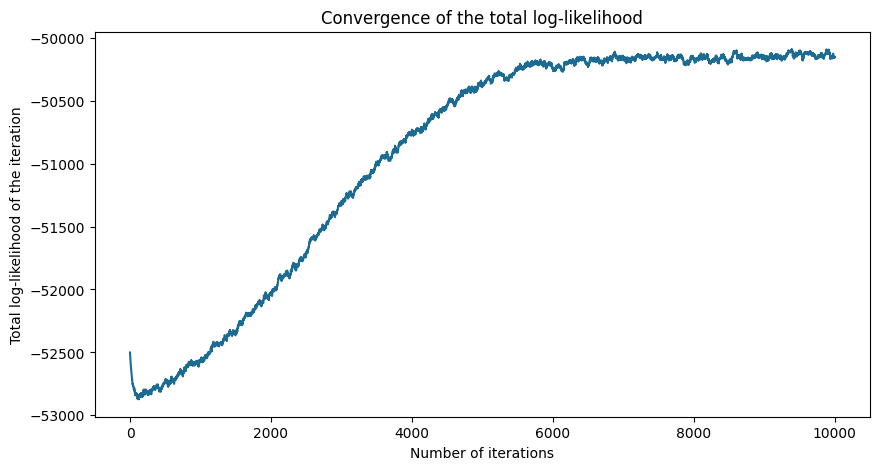

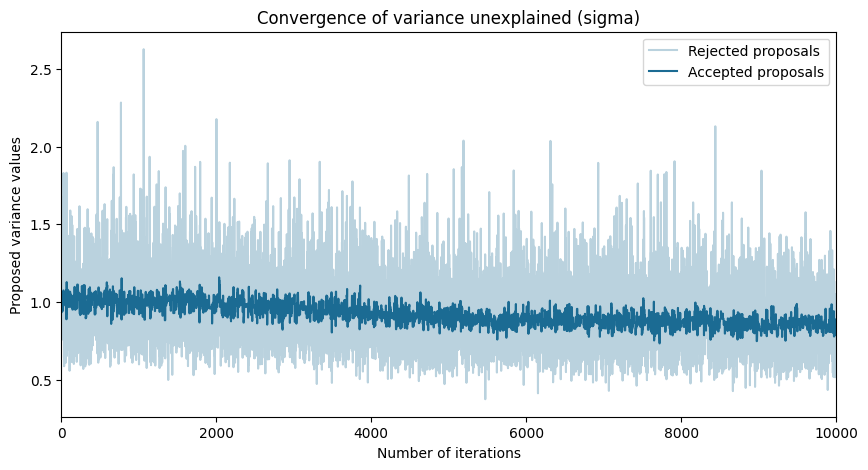

In [25]:
pSCoPE.plot_likelihood()
pSCoPE.plot_sigma(r=1)

In [26]:
pSCoPE.post_process(5000)

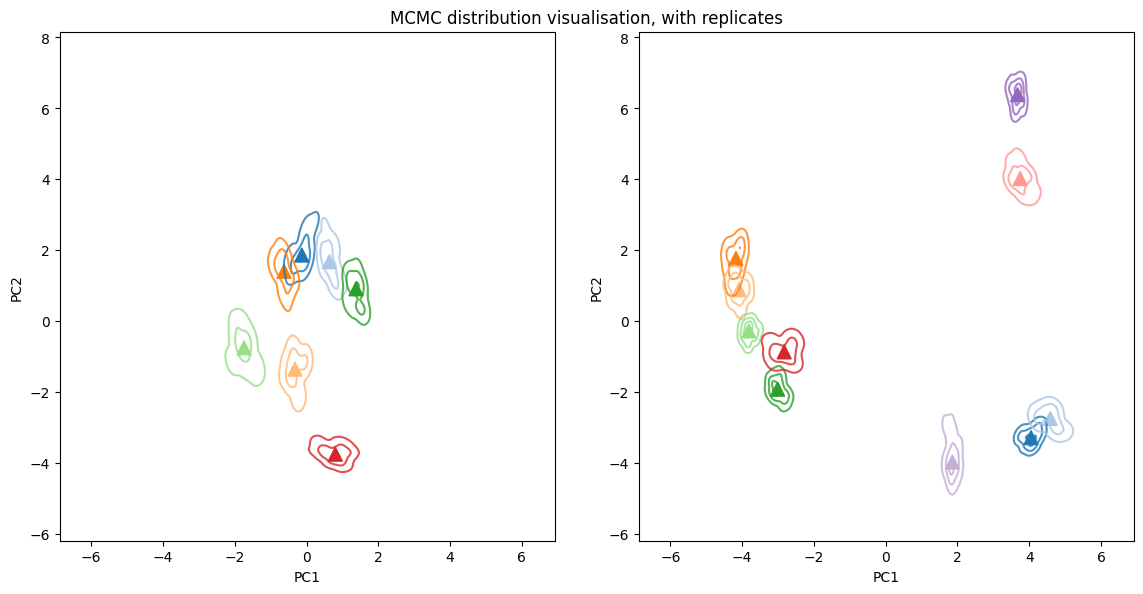

In [27]:
pSCoPE.X_contours(repwise=True, savefig='pSCoPE_repwise', reps=[28,36])


---
### plexDIA Fig.6p [2]

In [30]:
R = 3

# Dataframe loading (164 observations in total)
df = pd.read_csv('../datasets/plexDIA/Proteins_SC_IDs.txt', sep='\s+')
df = df.drop(columns=['prot']).T
df = df.iloc[index_natsorted(df.index)]
guide = pd.read_csv('../datasets/plexDIA/Meta_SC.tsv', sep='\s+', index_col=0)
guide = guide.set_index('id')
guide = guide.iloc[index_natsorted(guide.index)]
guide = guide[guide.index.isin(df.index)]

# The p_v most variate features
p_v = 100
id_v = np.argsort(np.var(data.values, axis=0))[-p_v:]

# Replicate 1
QE_A_id = list(guide[(guide['Instrument']=='Q-Exactive') & (guide['Digest']=='A')].index)
# Replicate 2    
QE_B_id = list(guide[(guide['Instrument']=='Q-Exactive') & (guide['Digest']=='B')].index)
# Replicate 3
timsTOFSCP_id = list(guide[(guide['Instrument']=='timsTOFSCP')].index)

# Text labels
textlabel = [list(guide.loc[QE_A_id]['Celltype'])]
textlabel.append([i.replace('_DB','') for i in list(guide.loc[QE_B_id]['Celltype'])])
textlabel.append([i.replace('_t','') for i in list(guide.loc[timsTOFSCP_id]['Celltype'])])
# Labels
color_dict = {'Melanoma': 0, 'PDAC': 1, 'U-937': 2}
label = [[color_dict[i] for i in textlabel[r]] for r in range(R)] 

# Formated list Y
Y_rep = [df.loc[QE_A_id].values, df.loc[QE_B_id].values, df.loc[timsTOFSCP_id].values]

# Create model instance
scaler = StandardScaler()
Y = [StandardScaler().fit_transform(rep)[:, id_v] for rep in Y_rep]
plexDIA = mcmcPPCA(Y, q=2)

Initialised with sigmas: [0.9853240947861386, 0.9895635599686065, 0.9930506640818374]


In [31]:
plexDIA.set_proposals(W=0.02, sigma=[51,50], X=0.02)
plexDIA.fit(iterations=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Current acceptance rates: W, 0.6396396396396477; sigma, 0.24057390724057418; X, 0.3626960293626988
Current acceptance rates: W, 0.5892946473236736; sigma, 0.2376188094047047; X, 0.3621810905452785
Current acceptance rates: W, 0.5521840613537782; sigma, 0.23752361898410923; X, 0.3477825941980653
Current acceptance rates: W, 0.5153788447111618; sigma, 0.23589230640993644; X, 0.3244144369425644
Current acceptance rates: W, 0.4734946989397684; sigma, 0.23764752950589946; X, 0.30492765219709783
Current acceptance rates: W, 0.43690615102514996; sigma, 0.2372617658498605; X, 0.29093737845195344
Current acceptance rates: W, 0.41434490641517985; sigma, 0.2374624946420858; X, 0.2827070533885666
Current acceptance rates: W, 0.3946743342917634; sigma, 0.23661290994706896; X, 0.2752427386756536
Current acceptance rates: W, 0.3755972885875976; sigma, 0.23528540208170365; X, 0.27028929140273317
Current acceptance rates: W, 0.3619361936193384; sigma, 0.23609027569422575; X, 0.2661266126612499


In [32]:
plexDIA.save('plexDIA_fig6p_MCMC')

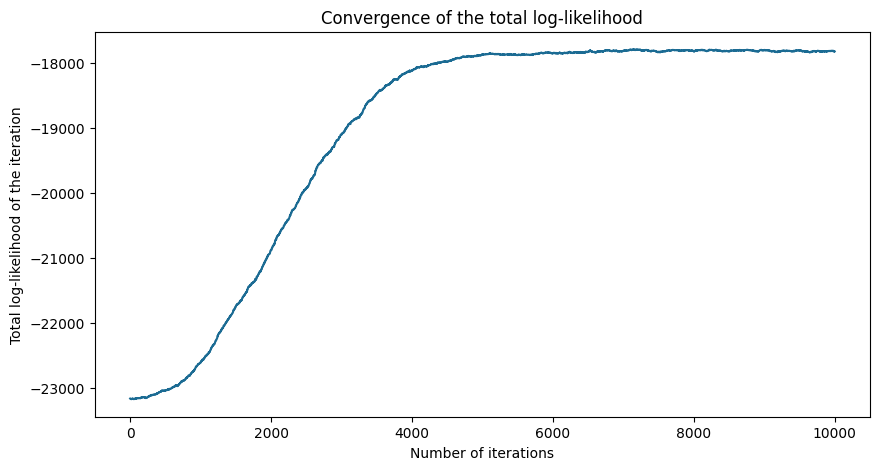

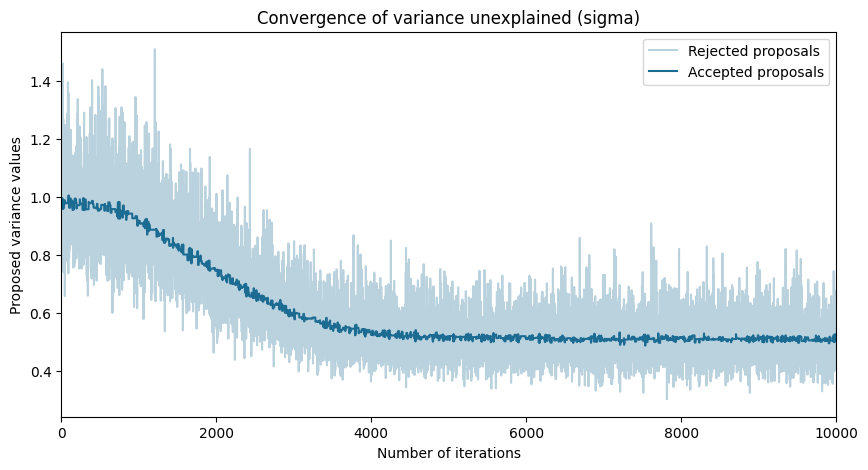

In [33]:
plexDIA.plot_likelihood()
plexDIA.plot_sigma(r=1)

In [34]:
plexDIA.post_process(burn_in=5000)

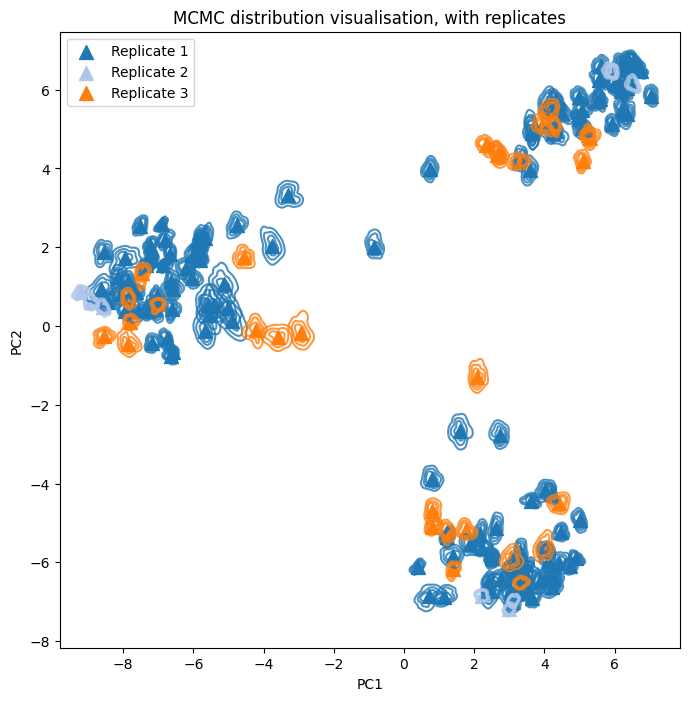

In [35]:
plexDIA.X_contours(repwise=False, savefig='plexDIA_together')


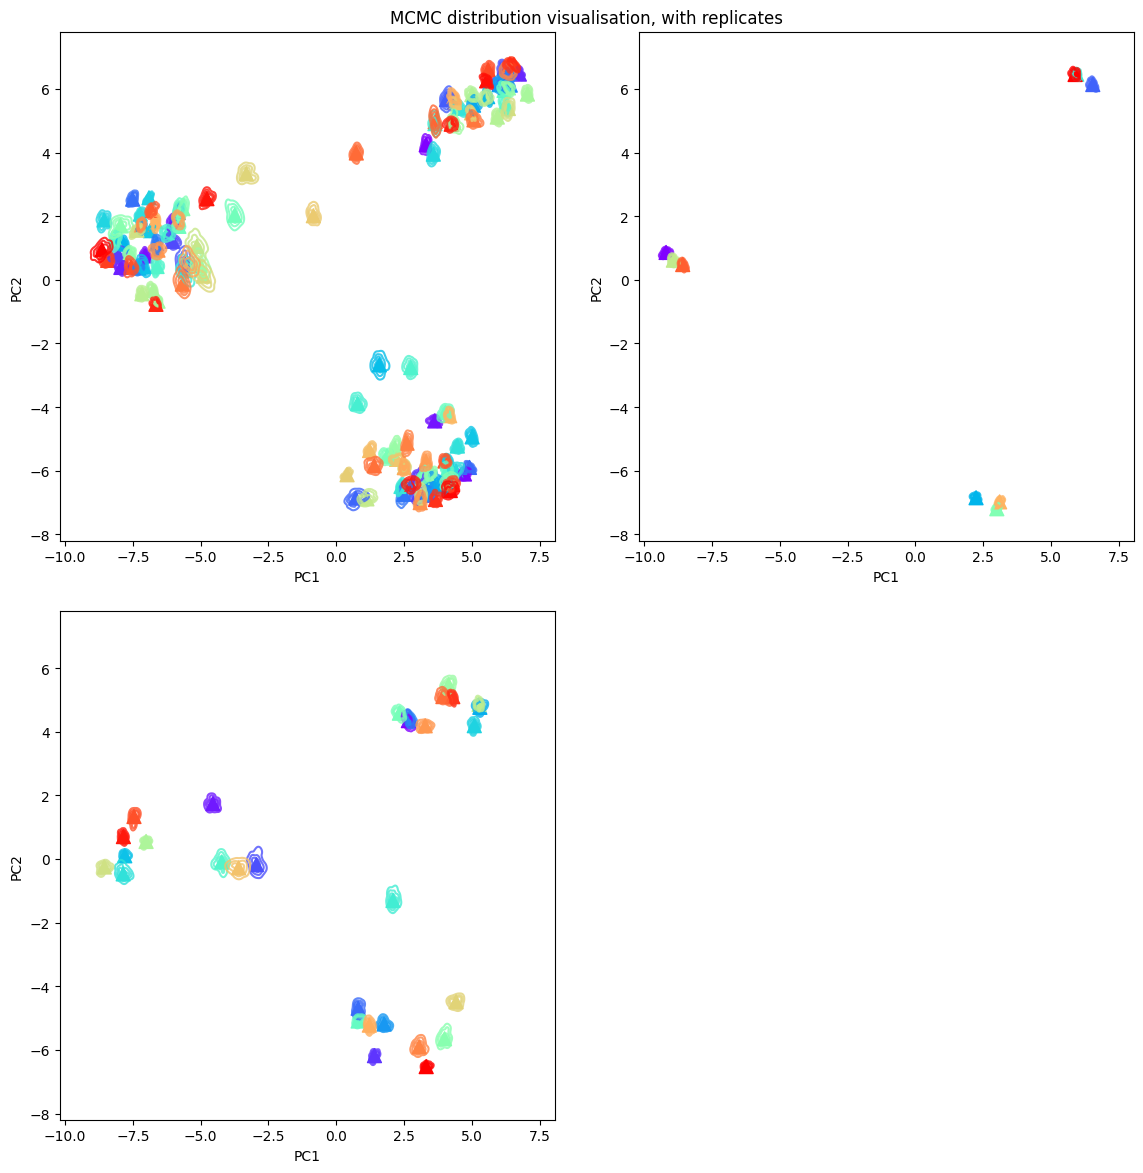

In [36]:
plexDIA.X_contours(repwise=True, savefig='plexDIA_repwise')
